In [51]:
import os
import ember
import lightgbm as lgb
import shap
import numpy as np
import pandas as pd

binary_name = "payload.bin" #set this to the binary name, put the ones u want to test in /binaries

data_dir = "../ember2018/"

In [52]:
# ~4 mns
binary_location = f"/workspaces/torment-nexus/binaries/{binary_name}"

emberdf = ember.read_metadata(data_dir)
X_train, y_train, X_test, y_test = ember.read_vectorized_features(data_dir, feature_version=2)
lgbm_model = lgb.Booster(model_file=os.path.join(data_dir, "ember_model_2018.txt"))
lgbm_model.params['objective'] = 'regression' # dunno why this never gets set but its needed for shap

In [53]:
# extractor1 = ember.PEFeatureExtractor(1)
extractor2 = ember.PEFeatureExtractor(2)

file_data = open(binary_location, "rb").read()

feature_vector = extractor2.feature_vector(file_data)
raw_features = extractor2.raw_features(file_data)

In [61]:
# holy shit this was something else

byte_histogram = [f"Byte Histogram {a}" for a in range(256)] #256

byte_entropy_histogram = [f"Byte Entropy Histogram {a}" for a in range(256)] #256

strings_1 = [f"string.{a}" for a in ["numstrings", "avlength", "printables"]]
strings_2 = [f"string.printabledist_{b}" for b in range(len(raw_features["strings"]["printabledist"]))]
strings_3 = [f"string.{a}" for a in ["entropy", "paths", "urls", "registry", "MZ"]] # 8 + 96
strings = np.concatenate((strings_1,strings_2,strings_3))

general_info = [f"general.{a}" for a in ["size", "vsize", "has_debug", "exports", "imports", "has_relocations", "has_resources", "has_signature", "has_tls", "symbols"]]

header_coff = ["header.coff.timestamp"]
header_coff_machine = [f"header.coff.machine_{a}" for a in range(10)]
header_coff_characteristics = [f"header.coff.characteristic_{a}" for a in range(10)]
header_coff_subsystem = [f"header.optional.subsystem_{a}" for a in range(10)]
header_coff_dll_characteristics = [f"header.optional.dll_characteristic_{a}" for a in range(10)]
header_coff_magic = [f"header.optional.magic_{a}" for a in range(10)]
header_optional = [f"header.optional.{a}" for a in ["major_image_version", "minor_image_version", "major_linker_version", "minor_linker_version", "major_operating_system_version", "minor_operating_system_version", "major_subsystem_version", "minor_subsystem_version", "sizeof_code", "sizeof_headers", "sizeof_heap_commit"]] #12
header = np.concatenate((header_coff,header_coff_machine,header_coff_characteristics,header_coff_subsystem,header_coff_dll_characteristics,header_coff_magic,header_optional))

sections_general = [f"sections.{a}" for a in ["section_count", "num_empty_sections", "num_unnamed_sections", "num_read_execute_sections", "num_write_sections",]] #JUST general
sections_section_sizes = [f"sections.section_{a}_size" for a in range(50)] # this messes with hashing which i will understand at a later time
sections_section_entropy = [f"sections.section_{a}_entropy" for a in range(50)]
sections_section_vsize = [f"sections.section_{a}_vsize" for a in range(50)]
sections_entry_name = [f"sections.entry_name_{a}" for a in range(50)]
sections_characteristics = [f"sections.characteristics_{a}" for a in range(50)]
sections = np.concatenate((sections_general, sections_section_sizes, sections_section_entropy, sections_section_vsize, sections_entry_name, sections_characteristics))

imports_libraries = [f"imports.libraries.library_{a}" for a in range(256)]
imports_imports = [f"imports.import_{a}" for a in range(1024)]
imports = np.concatenate((imports_libraries,imports_imports))

exports = [f"exports.export_{a}" for a in range(128)]

name_order = [a.lower() for a in ["EXPORT_TABLE", "IMPORT_TABLE", "RESOURCE_TABLE", "EXCEPTION_TABLE", "CERTIFICATE_TABLE","BASE_RELOCATION_TABLE", "DEBUG", "ARCHITECTURE", "GLOBAL_PTR", "TLS_TABLE", "LOAD_CONFIG_TABLE","BOUND_IMPORT", "IAT", "DELAY_IMPORT_DESCRIPTOR", "CLR_RUNTIME_HEADER"]]
data_directories_unflat = [[f"directories.{a}_size", f"directories.{a}_vaddress"] for a in name_order]
data_directories = [item for sublist in data_directories_unflat for item in sublist]



feature_names = np.concatenate((byte_histogram, byte_entropy_histogram, strings, general_info, header, sections, imports, exports, data_directories))

[len(byte_histogram) == 256, 
 len(byte_entropy_histogram) == 256, 
 len(strings) == 1 + 1 + 1 + 96 + 1 + 1 + 1 + 1 + 1,
 len(general_info) == 10,
 len(header) == 62, 
 len(sections) == 5 + 50 + 50 + 50 + 50 + 50,
 len(imports) == 1280,
 len(exports) == 128,
 len(data_directories) == 15 * 2,
 len(feature_names) == 2381 # Checks if the feature names are all properly assigned
]

[True, True, True, True, True, True, True, True, True, True]

In [55]:
explainer = shap.TreeExplainer(lgbm_model, feature_names=feature_names)
# shap_values = explainer(pd.DataFrame(X_train[:300]))
shap_values_single = explainer(np.array([feature_vector], dtype=np.float32))

In [56]:
shap.initjs()
# shap.force_plot(shap_values) # this isnt really useful but if you want to look you can

# Plot output

In [57]:
shap.force_plot(shap_values_single)

In [58]:
"""
You can see in the above graph that all of the features still have "Feature XXXX" instead of an actual name.
Forunately, there is something resembling a feature name that you can see below
"""
np.array(raw_features)

array({'sha256': '6c01370e4c4c73fb564a1b39481ac7b7bdb0346aa8a8e65c46d4fb136cad0373', 'histogram': [3451162, 342996, 301376, 120754, 152310, 168252, 82564, 79033, 205546, 62441, 61935, 42399, 46028, 44828, 40239, 263199, 108238, 48505, 28329, 33782, 44209, 28690, 20272, 19669, 71938, 25530, 18834, 21039, 20913, 22540, 20956, 47567, 81003, 20198, 19404, 23214, 643285, 14947, 18358, 15393, 56802, 36794, 24583, 14355, 21926, 20711, 33915, 15582, 57165, 81624, 25338, 22671, 31788, 43786, 25128, 19067, 47683, 53403, 14810, 30967, 17299, 29846, 17388, 14082, 84898, 44604, 20540, 18075, 287214, 28070, 25089, 28872, 892702, 82515, 19721, 13698, 176602, 38347, 14236, 16250, 58585, 15162, 21810, 17086, 110107, 16472, 16774, 15617, 37923, 16008, 16568, 14585, 51501, 10003, 8932, 16820, 42244, 21395, 13860, 23580, 23018, 36066, 62663, 15841, 32436, 24184, 14242, 14227, 72606, 19467, 26304, 26052, 38304, 14975, 31198, 40522, 72835, 47227, 18886, 14652, 37838, 15400, 16087, 17260, 100920, 14046, 1080

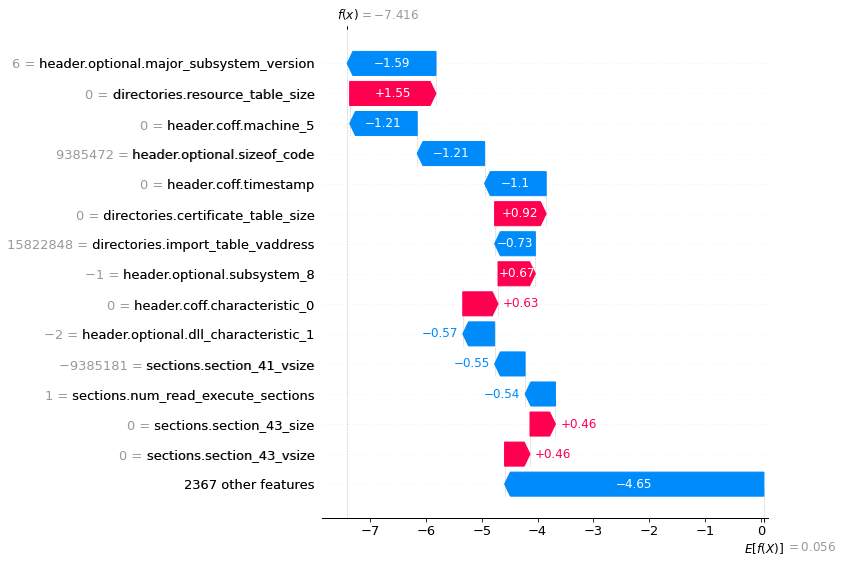

In [59]:
shap.plots.waterfall(shap_values_single[0], max_display=15)

In [60]:
strings

['string.numstrings',
 'string.avlength',
 'string.printables',
 "string.['printabledist 0', 'printabledist 1', 'printabledist 2', 'printabledist 3', 'printabledist 4', 'printabledist 5', 'printabledist 6', 'printabledist 7', 'printabledist 8', 'printabledist 9', 'printabledist 10', 'printabledist 11', 'printabledist 12', 'printabledist 13', 'printabledist 14', 'printabledist 15', 'printabledist 16', 'printabledist 17', 'printabledist 18', 'printabledist 19', 'printabledist 20', 'printabledist 21', 'printabledist 22', 'printabledist 23', 'printabledist 24', 'printabledist 25', 'printabledist 26', 'printabledist 27', 'printabledist 28', 'printabledist 29', 'printabledist 30', 'printabledist 31', 'printabledist 32', 'printabledist 33', 'printabledist 34', 'printabledist 35', 'printabledist 36', 'printabledist 37', 'printabledist 38', 'printabledist 39', 'printabledist 40', 'printabledist 41', 'printabledist 42', 'printabledist 43', 'printabledist 44', 'printabledist 45', 'printabledist 4